In [58]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scarches as sca
import scvelo as scv
import numba, scvi, umap, scipy, sklearn, mellon, scprep, anndata, magic

# package version
# Note: to reproduce the results in the manuscript, please use the exact versions of the packages as shown below.
print('scanpy version: ' + sc.__version__)
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)
print('scipy version: ' + scipy.__version__)
print('numba version: ' + numba.__version__)
print('scvi version: ' + scvi.__version__)
print('umap version: ' + umap.__version__)
print('scikit-learn version: ' + sklearn.__version__)
print('mellon version: ' + mellon.__version__)
print('scprep version: ' + scprep.__version__)
print('anndata version: ' + anndata.__version__)
print('magic version: ' + magic.__version__)

# scanpy version: 1.10.1
# pandas version: 1.5.3
# numpy version: 1.26.4
# scipy version: 1.13.0
# numba version: 0.59.1
# scvi version: 1.1.5
# umap version: 0.5.6
# scikit-learn version: 1.4.2
# mellon version: 1.4.3
# scprep version: 1.2.3
# anndata version: 0.10.7
# magic version: 3.0.0

sc.set_figure_params(figsize = (5, 5), dpi_save = 300)
sns.set_style("white")

scanpy version: 1.10.1
pandas version: 1.5.3
numpy version: 1.26.4
scipy version: 1.13.0
numba version: 0.59.1
scvi version: 1.1.5
umap version: 0.5.6
scikit-learn version: 1.4.2
mellon version: 1.4.3
scprep version: 1.2.3
anndata version: 0.10.7
magic version: 3.0.0


# Figure 5

## QC for micropattern D6-D10 data (unnecessary to run)

(9160, 18082)
(3398, 18082)
(4173, 18082)
(8702, 18082)
(3228, 18082)
(3964, 18082)
(8702, 15760)
(3228, 14939)
(3964, 15001)
(8702, 15831)
(3228, 15831)
(3964, 15831)


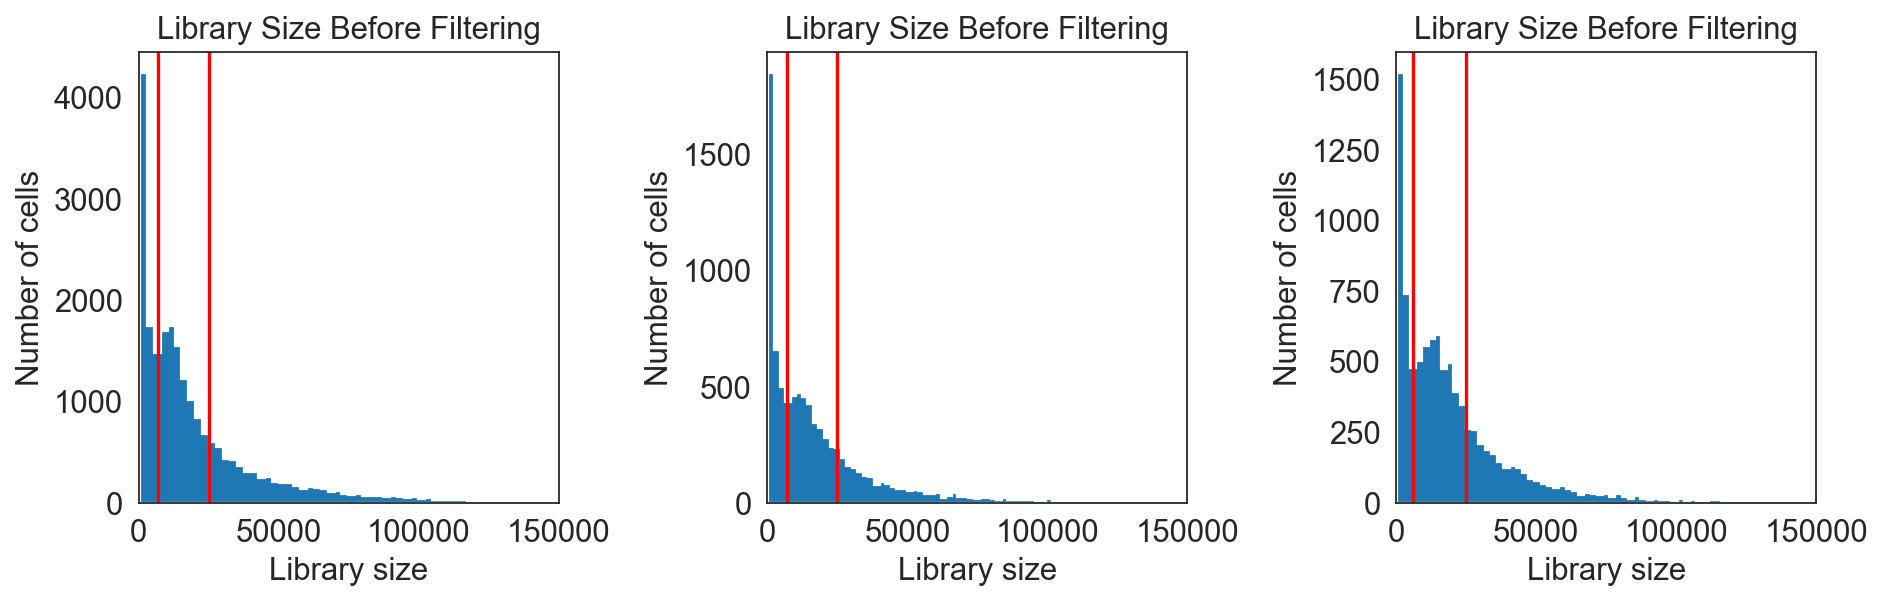

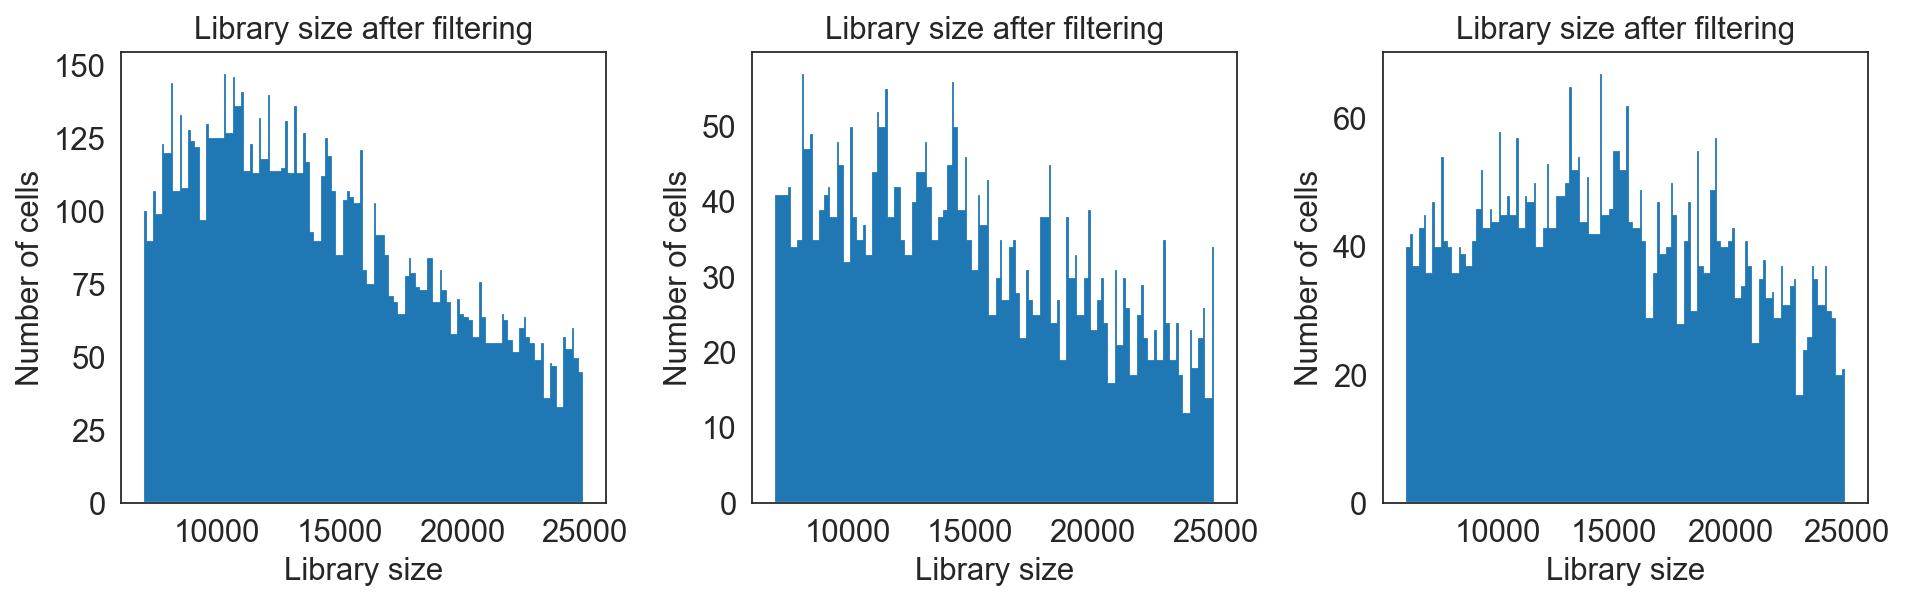

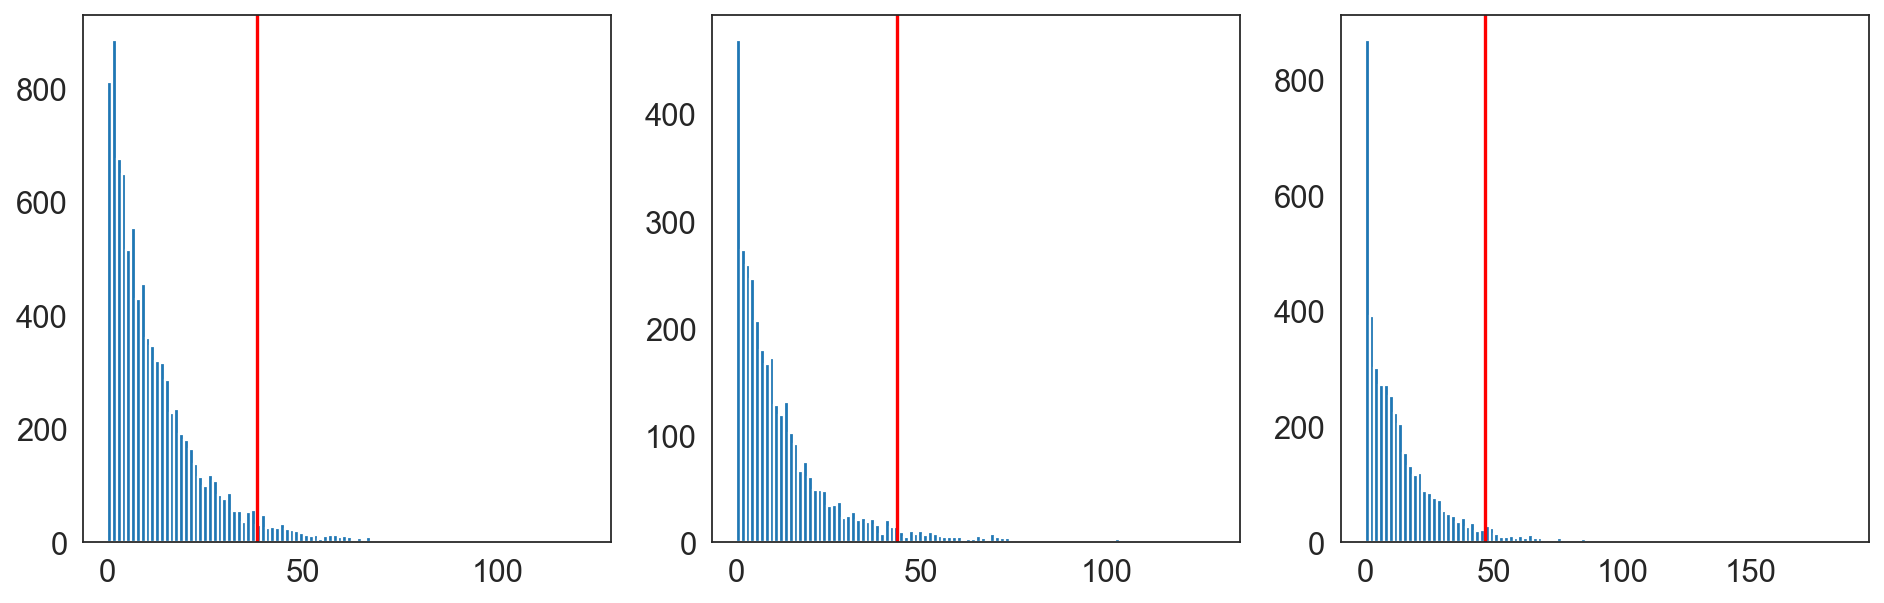

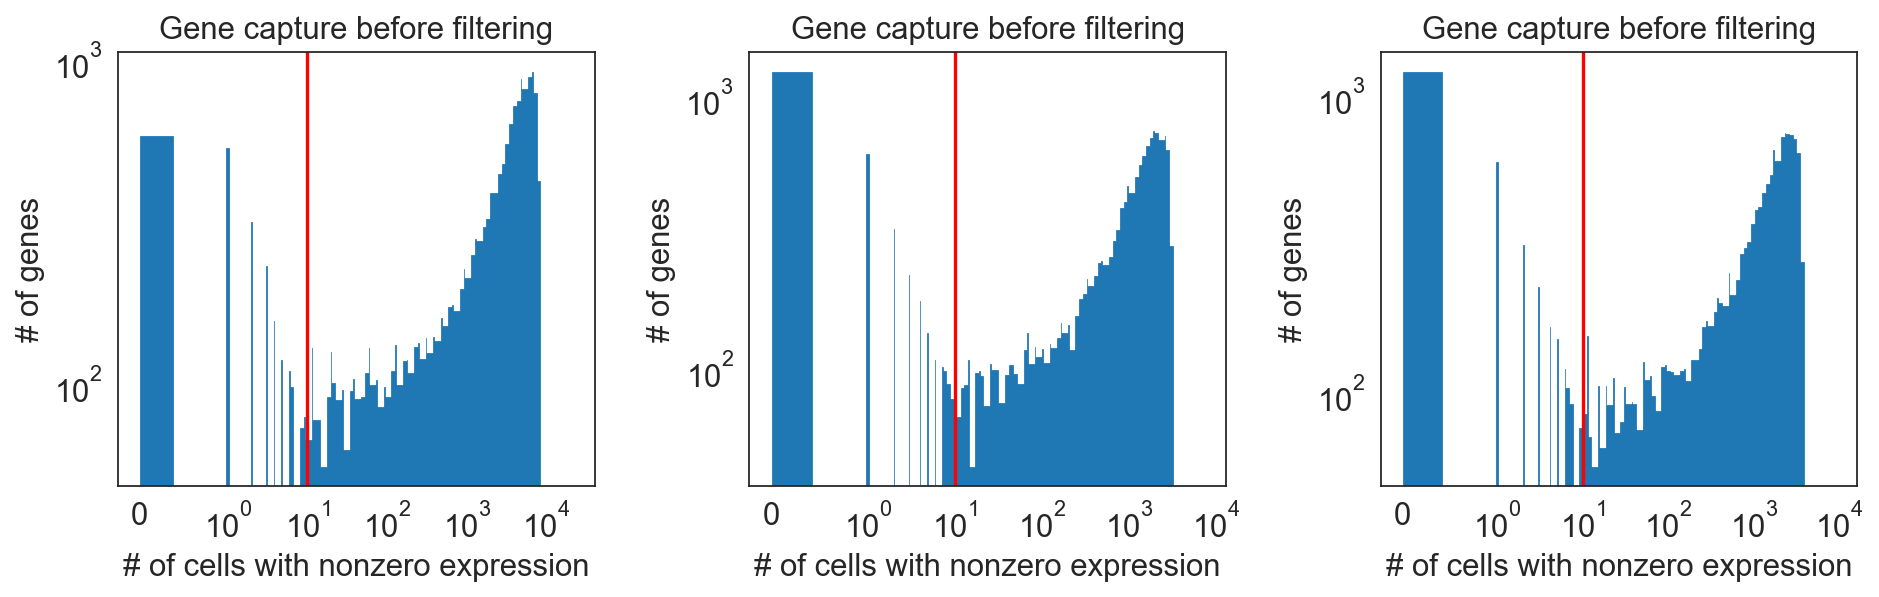

In [52]:
# D6-D10 micropattern datasets can be downloaded from GEO with the accession number ?
bc_2 = scprep.io.load_10X('11288-BC/11288-BC/10x_summary_11288-BC/11288-BC-2_sample_filtered_feature_bc_matrix/', sparse=True, gene_labels='both')
bc_3 = scprep.io.load_10X('11288-BC/11288-BC/10x_summary_11288-BC/11288-BC-3_sample_filtered_feature_bc_matrix/', sparse=True, gene_labels='both')
bc_4 = scprep.io.load_10X('11288-BC/11288-BC/10x_summary_11288-BC/11288-BC-4_sample_filtered_feature_bc_matrix/', sparse=True, gene_labels='both')
data = {
    'bc_2': bc_2,
    'bc_3': bc_3,
    'bc_4': bc_4
}
conditions = ['bc_2', 'bc_3', 'bc_4']

libcutoffs = [(7000,25000),(7000,25000),(6000,25000)]
fig, axes = plt.subplots(1,3, figsize=(12,4))
# This makes it easier to iterate through the axes
axes = axes.flatten()
for i, ax in enumerate(axes):
    scprep.plot.plot_library_size(data[conditions[i]], cutoff=libcutoffs[i], log=False, title='Library Size Before Filtering', ax=ax);
    ax.set_xlim([0, 150000])
fig.tight_layout()

fig, axes = plt.subplots(1,3, figsize=(12,4))
# This makes it easier to iterate through the axes
axes = axes.flatten()
for i, ax in enumerate(axes):
    scprep.plot.plot_library_size(data[conditions[i]], log=False, range=libcutoffs[i], title='Library size after filtering',ax=ax);
fig.tight_layout()   

data_filt = {};
for i in range(0,3):
    data_filt[conditions[i]] = scprep.filter.filter_library_size(data[conditions[i]], cutoff=libcutoffs[i], keep_cells='between');
    print(data_filt[conditions[i]].shape)
    
fig, axes = plt.subplots(1,3, figsize=(12,4))
# This makes it easier to iterate through the axes
axes = axes.flatten()
for i, ax in enumerate(axes):
    mitochondrial_gene_list = np.array([g.startswith('MT-') for g in data_filt[conditions[i]].columns])
    mito_exp =  data_filt[conditions[i]].loc[:,mitochondrial_gene_list].mean(axis=1)
    mtcutoff = np.percentile(mito_exp, 95)
    ax.hist(mito_exp, bins=100)
    ax.axvline(mtcutoff, color = 'red')
fig.tight_layout()

for i in range(0,3) :
   mitochondrial_gene_list = np.array([g.startswith('MT-') for g in data_filt[conditions[i]].columns])
   mito_exp =  np.array(data_filt[conditions[i]].loc[:,mitochondrial_gene_list].mean(axis=1))
   data_filt[conditions[i]] = scprep.filter.filter_values(data = data_filt[conditions[i]], values = mito_exp, percentile = 95, keep_cells='below')
   print(data_filt[conditions[i]].shape)
   
fig, axes = plt.subplots(1,3, figsize=(12,4))
# This makes it easier to iterate through the axes
axes = axes.flatten()
for i, ax in enumerate(axes):
    scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt[conditions[i]]), log=True, cutoff=10,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes',ax=ax);
fig.tight_layout() 

data_filt_tmp = {}
for i in range(0,3) :
    data_filt_tmp[conditions[i]] = scprep.filter.filter_rare_genes(data_filt[conditions[i]], min_cells=10)
    print(data_filt_tmp[conditions[i]].shape)
    
cols = []
for i in range(0,3) :
    cols = np.union1d(cols, data_filt_tmp[conditions[i]].columns)
cols.shape

for i in range(0,3):
    data_filt[conditions[i]] = data_filt[conditions[i]][cols]
    print(data_filt[conditions[i]][cols].shape)
    
filtered_batches = []
for key in data_filt:
    filtered_batches.append(data_filt[key])
data_combined, sample_labels = scprep.utils.combine_batches(filtered_batches, conditions)

adata_combined = anndata.AnnData(X=data_combined)
adata_combined.obs['sample_labels'] = sample_labels
del data, data_filt, data_filt_tmp, data_combined, sample_labels, filtered_batches

## Figures

In [16]:
# Integrated and processed D2-D10 micropattern adata can be downloaded from GEO with the accession number ?
adata_micropattern_full = sc.read_h5ad('241011_adata_int_noraw.h5ad')
micropattern_cmap = list(plt.colormaps.get_cmap('tab20').colors)
micropattern_cmap[3] = micropattern_cmap[18]
micropattern_cmap[13] = micropattern_cmap[16]
micropattern_cmap = dict(zip(adata_micropattern_full.obs['leiden_sub_sub2'].cat.categories, micropattern_cmap))
adata_micropattern_full.obs['stage'] = adata_micropattern_full.obs['sample_labels'].replace({
    '48h-1': 'D2',
    '48h-2': 'D2',
    '72h-1': 'D3',
    '72h-2': 'D3',
    '96h-1': 'D4',
    '96h-2': 'D4',
    'bc_2': 'D6',
    'bc_3': 'D8',
    'bc_4': 'D10'
})

In [42]:
# load scvi model (unnecessary to load)
model = scvi.model.SCVI.load('scvi_model_micropattern_48-96_D6_D8_D10_hvg_1500_cc_hvg_0', adata = adata_micropattern_full)

INFO     File scvi_model_micropattern_48-96_D6_D8_D10_hvg_1500_cc_hvg_0\model.pt already downloaded                


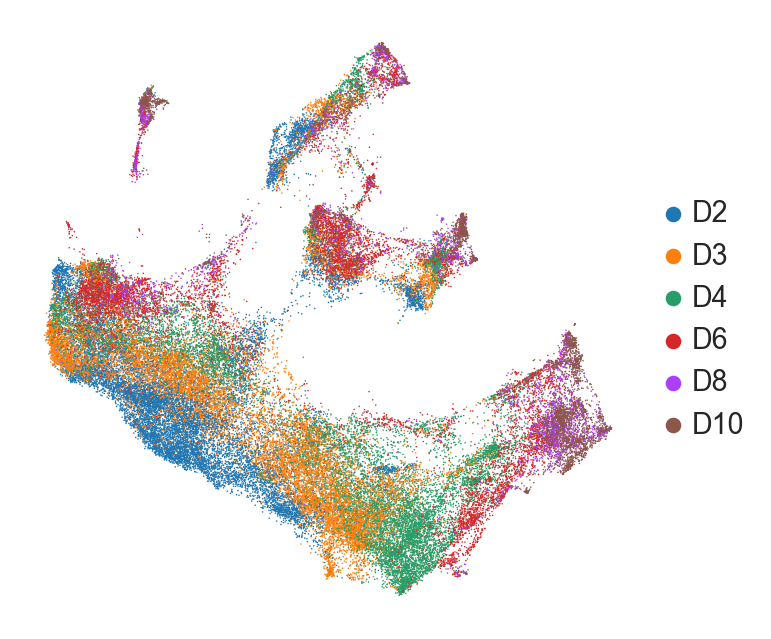

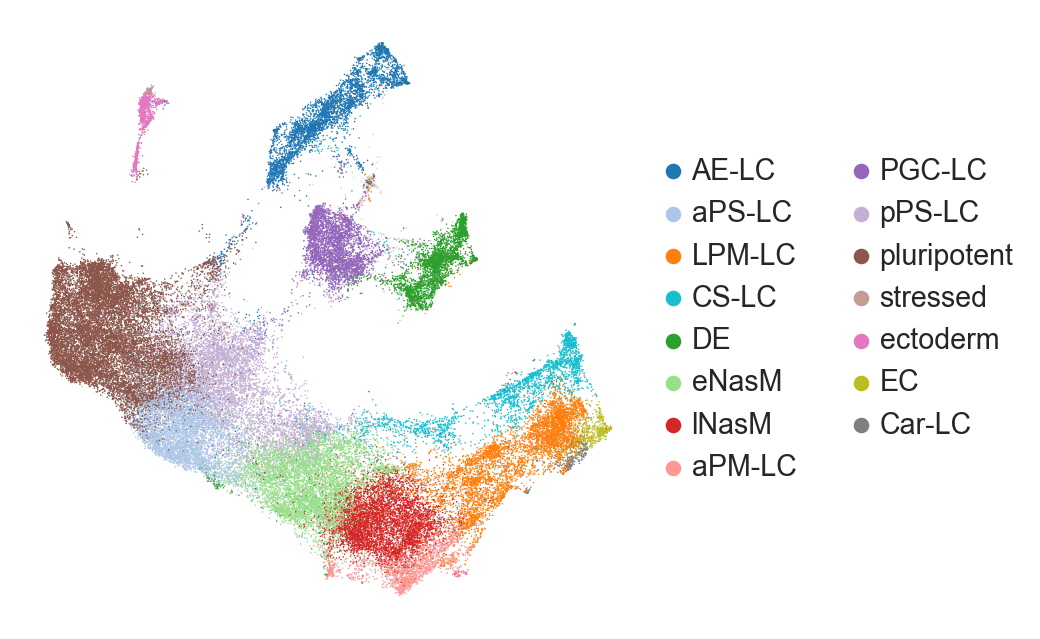

In [46]:
sc.pl.umap(
    adata_micropattern_full,
    frameon = False,
    color = 'stage',
    na_in_legend = False,
    title = ''
)
sc.pl.umap(
    adata_micropattern_full,
    frameon = False,
    color = 'leiden_sub_sub2',
    palette = micropattern_cmap,
    na_in_legend = False,
    title = ''
)

# Supplementary Figure 2

## Micropattern

In [23]:
# Integrated and processed D2-D4 micropattern adata can be downloaded from GEO with the accession number ?
adata_micropattern_old = sc.read_h5ad('./adata_timeseries_all_cc_hvg1000_leiden10_23_v3.h5ad')
adata_micropattern_old.obs['stage'] = adata_micropattern_old.obs['sample_labels'].replace({
    '48h-1': '48h',
    '48h-2': '48h',
    '72h-1': '72h',
    '72h-2': '72h',
    '96h-1': '96h',
    '96h-2': '96h'
})
for st in ['48h', '72h', '96h']:
    adata_micropattern_old.obs[st] = adata_micropattern_old.obs['leiden_sub']
    adata_micropattern_old.obs.loc[adata_micropattern_old.obs['stage'] != st, st] = np.nan

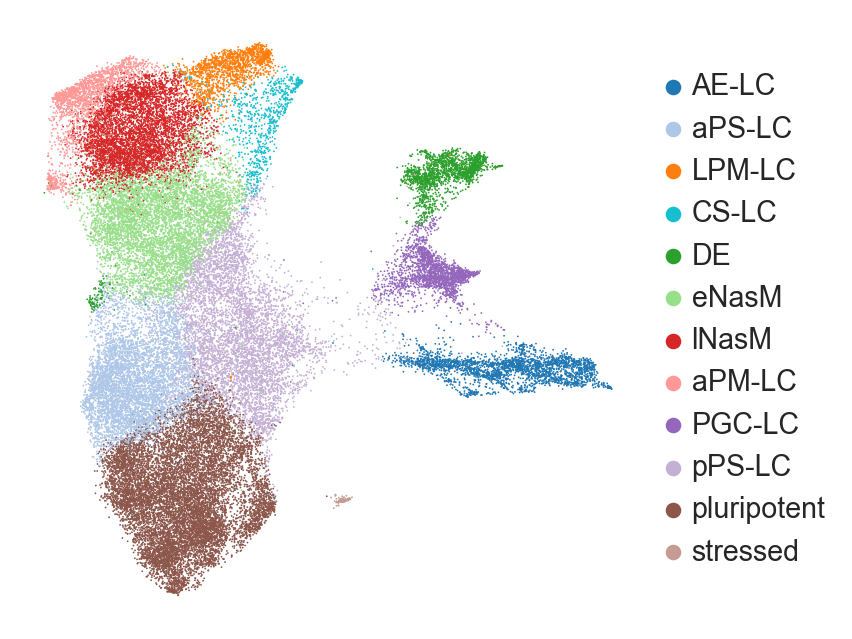

In [66]:
sc.pl.umap(
    adata_micropattern_old,
    color = 'leiden_sub',
    palette = micropattern_cmap,
    frameon = False,
    title = ''
)

In [67]:
# diffusion map
sc.pp.neighbors(adata_micropattern_old, n_neighbors=100, use_rep='X_scVI_cc', method='gauss')
sc.tl.diffmap(adata_micropattern_old)

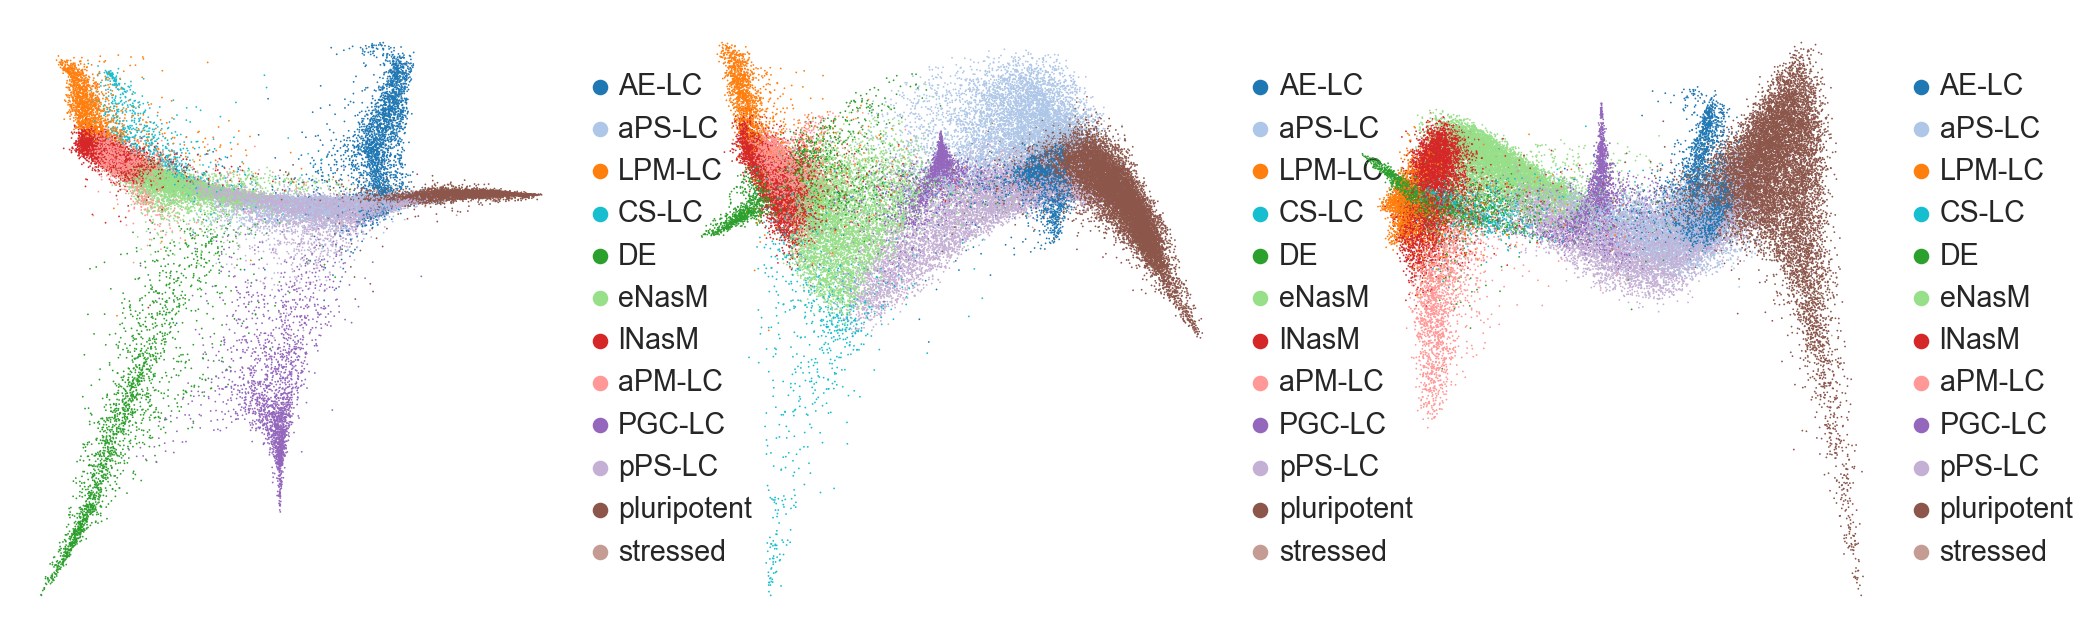

In [68]:
scv.pl.scatter(
    adata_micropattern_old, 
    basis = 'X_diffmap', 
    components = ["1, 3", "1, 8", "1, 13"], 
    color = 'leiden_sub',
    palette = micropattern_cmap,
    legend_loc = 'right',
    title = '',
)

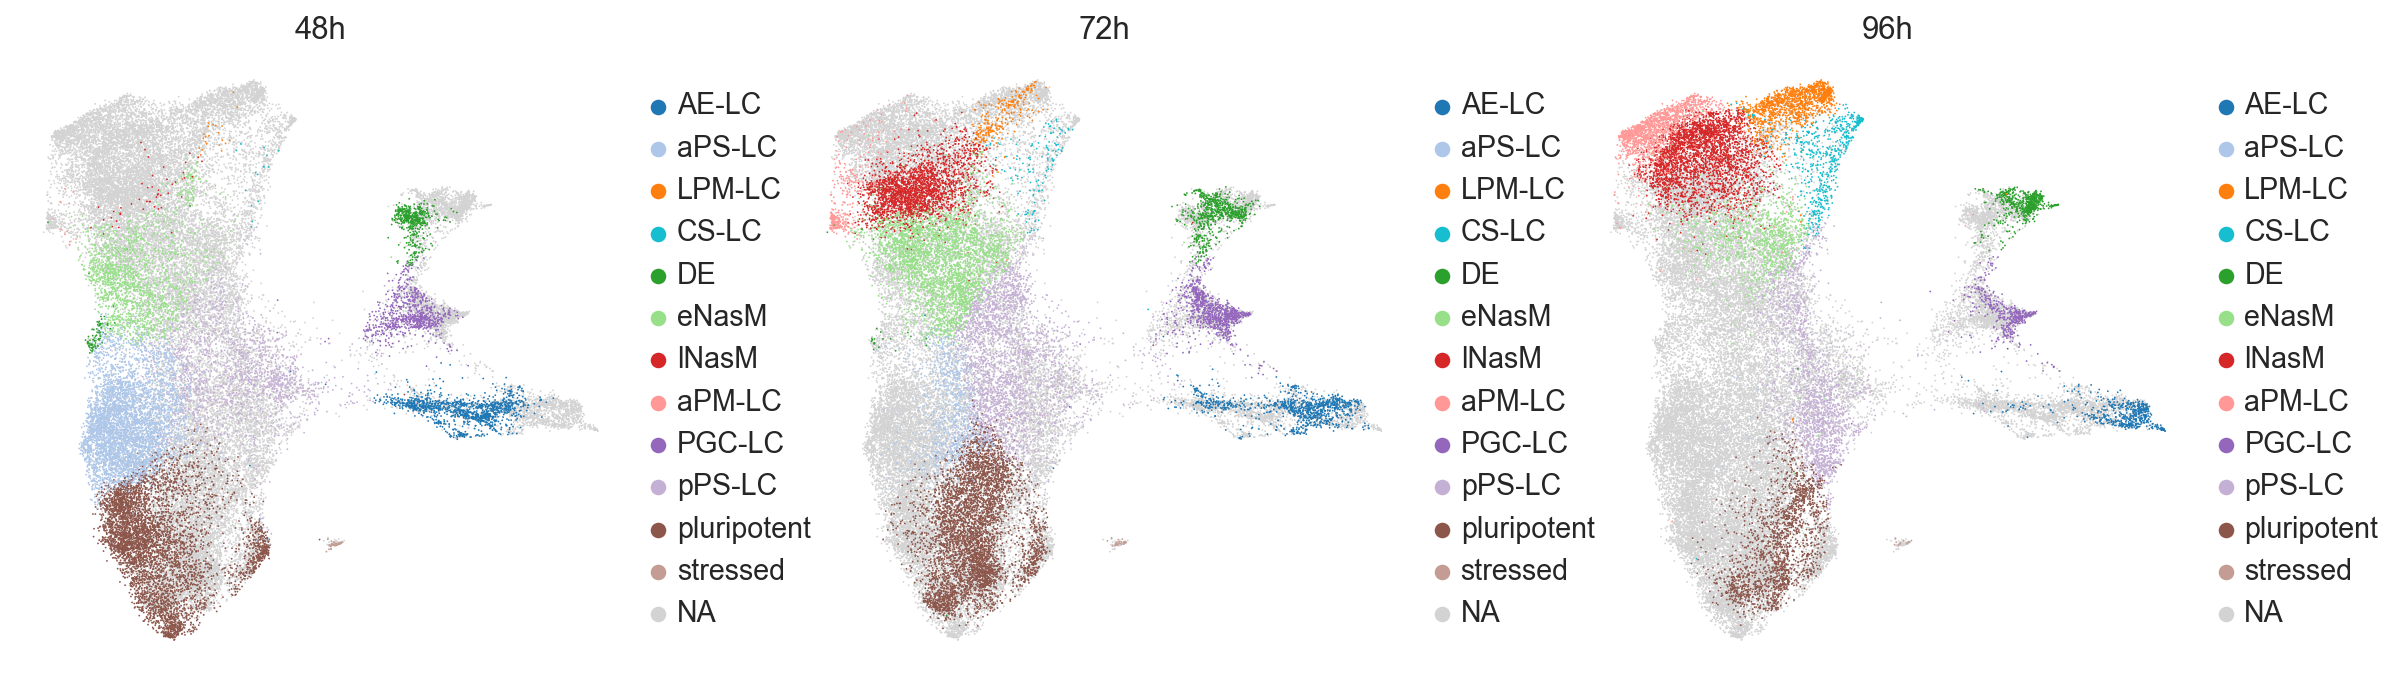

In [25]:
sc.pl.umap(
    adata_micropattern_old,
    color = ['48h', '72h', '96h'],
    palette = micropattern_cmap,
    frameon = False
)

## Monkey

In [63]:
adata_on_monkey = sc.read_h5ad('./adata_integrate_to_monkey.h5ad')
adata_on_monkey = adata_on_monkey.raw.to_adata()
adata_on_monkey_monkey = adata_on_monkey[adata_on_monkey.obs['sample'].str.contains('CS')].copy()
adata_on_monkey_micropattern = adata_on_monkey[~adata_on_monkey.obs['sample'].str.contains('CS|human')].copy()
del adata_on_monkey

# compute magic expression for monkey data
expr_df = adata_on_monkey_monkey.to_df()
for ct in adata_on_monkey_monkey.obs['sample'].cat.categories:
    expr_df_sp = expr_df[adata_on_monkey_monkey.obs['sample'] == ct].copy()
    magic_op = magic.MAGIC(random_state = 1, knn = 5, t = 1)
    expr_df_sub = magic_op.fit_transform(expr_df_sp)
    expr_df_sub = magic_op.transform()
    expr_df.loc[adata_on_monkey_monkey.obs['sample'] == ct] = expr_df_sub
adata_on_monkey_monkey.layers['magic'] = np.array(expr_df)

# compute magic expression for micropattern data
expr_df = adata_on_monkey_micropattern.to_df()
for ct in adata_on_monkey_micropattern.obs['sample'].cat.categories:
    expr_df_sp = expr_df[adata_on_monkey_micropattern.obs['sample'] == ct].copy()
    magic_op = magic.MAGIC(random_state = 1, knn = 5, t = 1)
    expr_df_sub = magic_op.fit_transform(expr_df_sp)
    expr_df_sub = magic_op.transform()
    expr_df.loc[adata_on_monkey_micropattern.obs['sample'] == ct] = expr_df_sub
adata_on_monkey_micropattern.layers['magic'] = np.array(expr_df)

Calculating MAGIC...
  Running MAGIC on 3380 cells and 32056 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.87 seconds.
    Calculating affinities...
    Calculated affinities in 0.90 seconds.
  Calculated graph and diffusion operator in 10.82 seconds.
  Running MAGIC with `solver='exact'` on 32056-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 5.02 seconds.
Calculated MAGIC in 16.09 seconds.
Calculating MAGIC...
  Running MAGIC on 7764 cells and 32056 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 18.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.12 seconds.
    Calculating affinities...
    Calculated affinities in 3.45 seconds.
  Calculated graph 

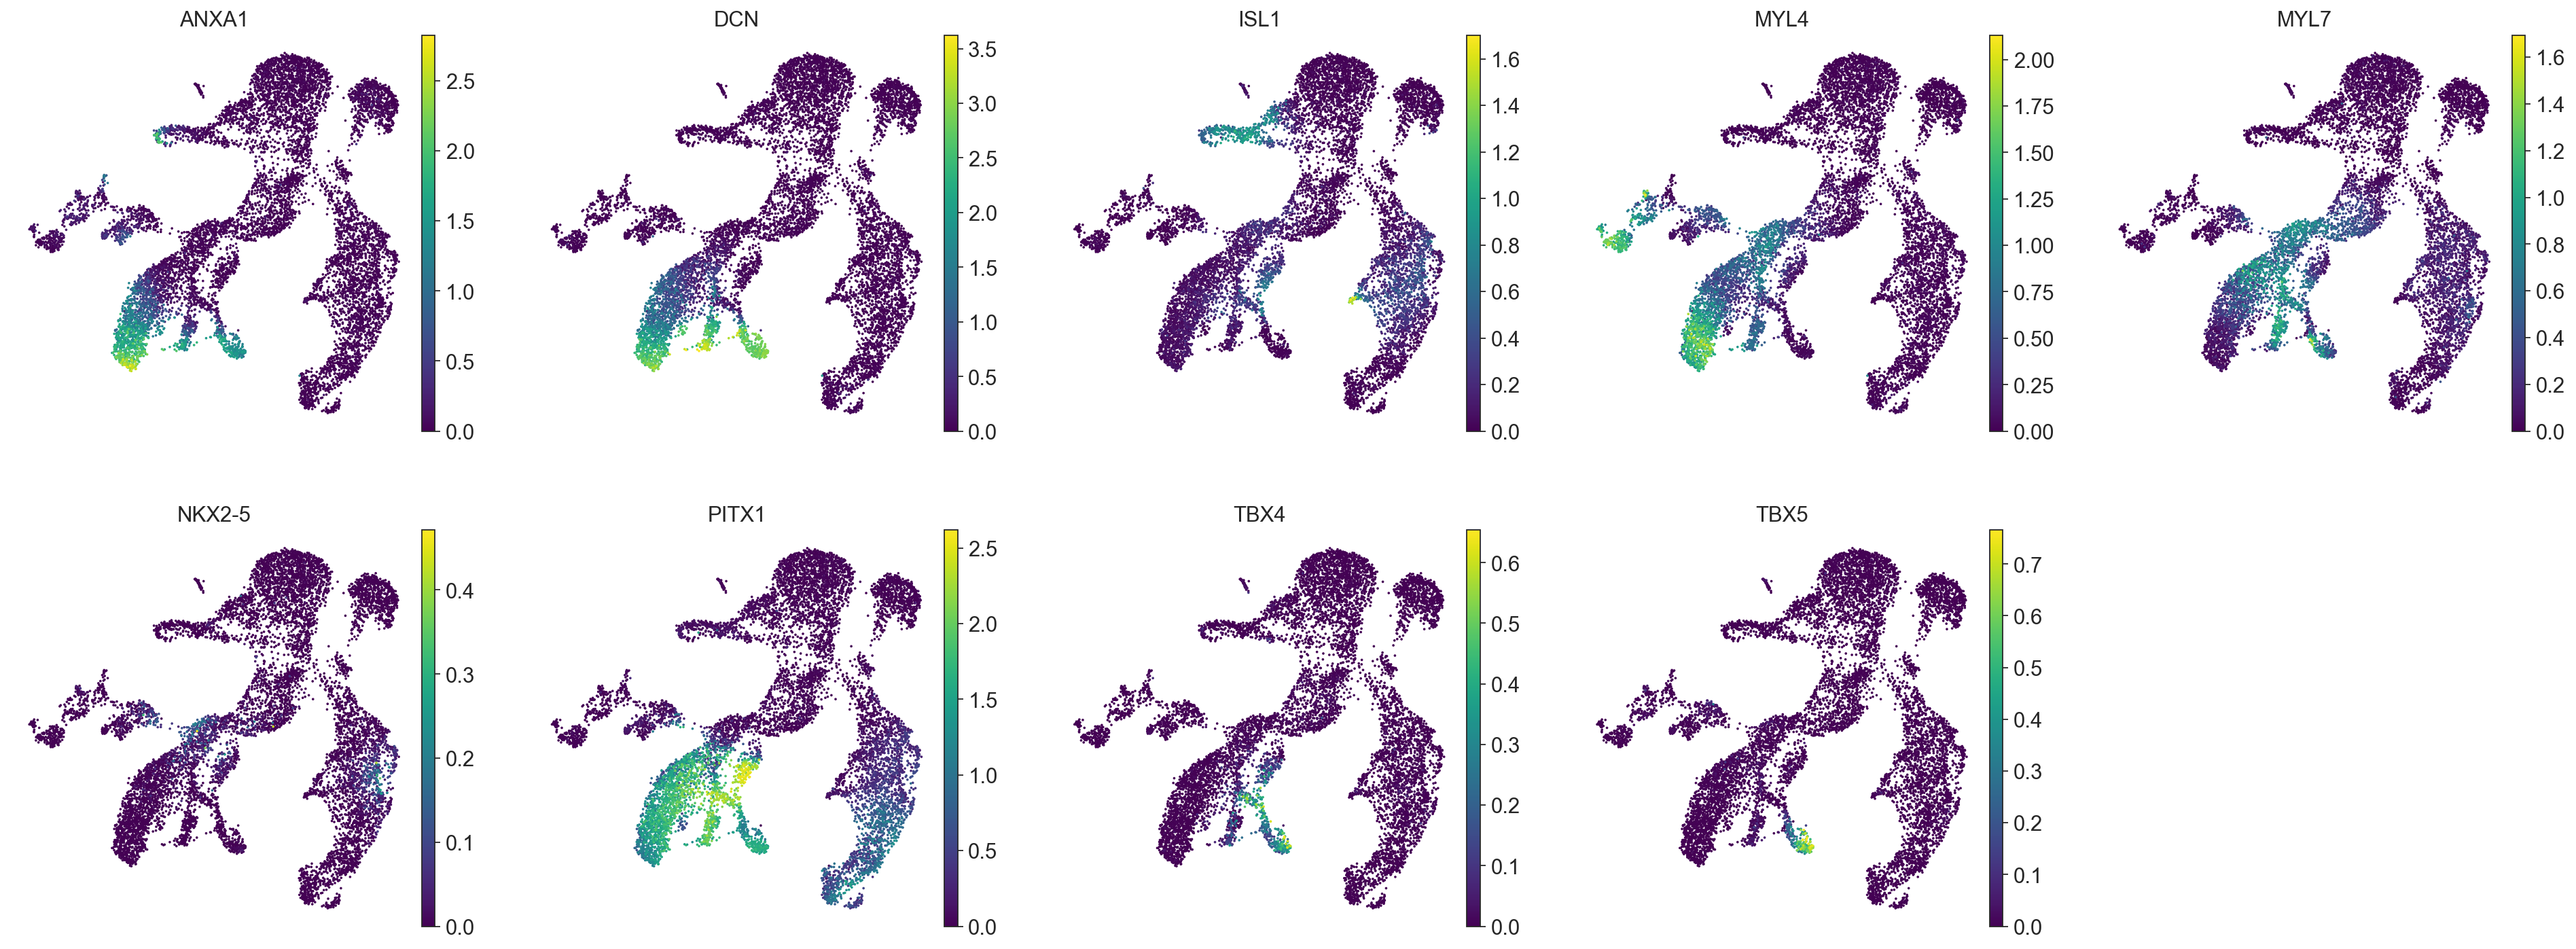

In [64]:
genes_of_interest = ['ANXA1', 'DCN', 'ISL1', 'MYL4', 'MYL7', 'NKX2-5', 'PITX1', 'TBX4', 'TBX5']
sc.pl.embedding(
    adata_on_monkey_monkey,
    basis = 'X_all2monkey',
    color = genes_of_interest,
    ncols = 5,
    layer = 'magic',
    frameon = False,
    cmap = 'viridis'
)

Text(0.5, 1.0, 'micropattern D2-D4 log1p RGB overlay monkey CS8')

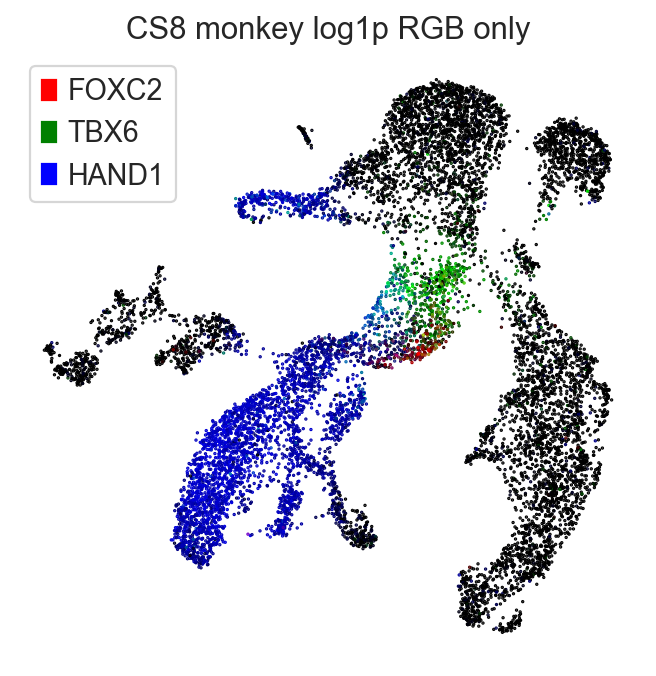

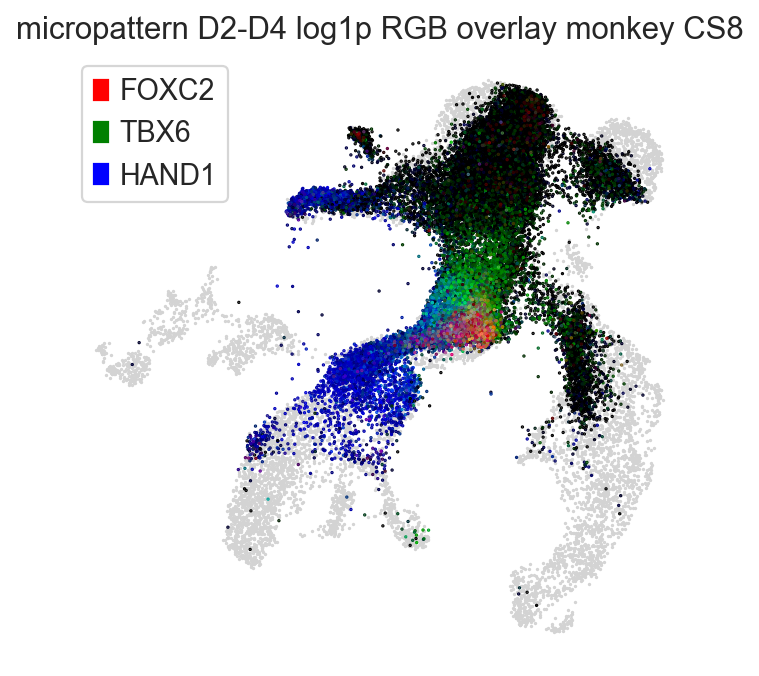

In [65]:
genes_disp = ['FOXC2', 'TBX6', 'HAND1']
legend_handles = [
    patches.Patch(color='red', label='FOXC2'),
    patches.Patch(color='green', label='TBX6'),
    patches.Patch(color='blue', label='HAND1')
]
x = np.array(adata_on_monkey_monkey[:, genes_disp].X.toarray())
permute = x[:, 0].argsort()
y = x / np.max(x, axis=0)
monkey_coords = adata_on_monkey_monkey.obsm['X_all2monkey']
fig, ax = plt.subplots(figsize = (5, 5))
ax.scatter(monkey_coords[permute, 0], monkey_coords[permute, 1], c = y[permute, :], s = 0.25)
ax.legend(handles=legend_handles, loc='upper left')
ax.axis('off')
ax.set_title('CS8 monkey log1p RGB only')

x = np.array(adata_on_monkey_micropattern[:, genes_disp].X.toarray())
permute = x[:, 0].argsort()
y = x / np.max(x, axis=0)
micropattern_coords = adata_on_monkey_micropattern.obsm['X_all2monkey']
fig, ax = plt.subplots(figsize = (5, 5))
scprep.plot.scatter2d(monkey_coords, c = [0.827, 0.827, 0.827], ticks=False, label_prefix='umap', ax=ax, s=0.25)
ax.scatter(micropattern_coords[permute, 0], micropattern_coords[permute, 1], c = y[permute, :], s = 0.25)
ax.legend(handles=legend_handles, loc='upper left')
ax.axis('off')
ax.set_title('micropattern D2-D4 log1p RGB overlay monkey CS8')

# Supplementary Figure 8

## Micropattern diffusion map

In [47]:
sc.pp.neighbors(adata_micropattern_full, use_rep = 'X_scvi', method = 'gauss', n_neighbors = 50)
sc.tl.diffmap(adata_micropattern_full)

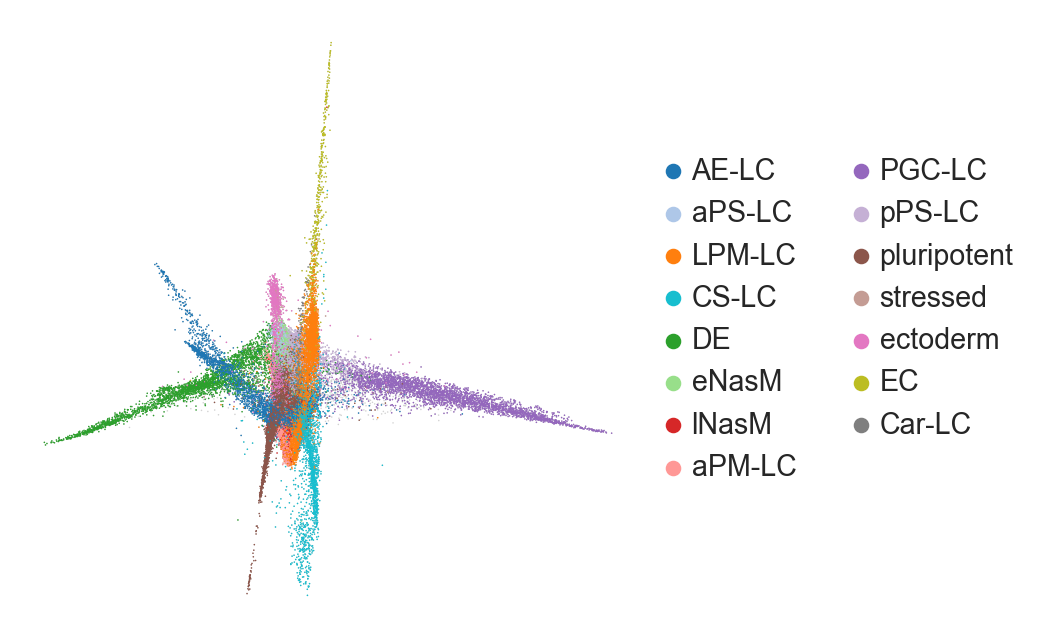

In [51]:
scv.pl.scatter(
    adata_micropattern_full, 
    basis = 'X_diffmap', 
    components = "5, 9", 
    color = 'leiden_sub_sub2',
    palette = micropattern_cmap,
    legend_loc = 'right',
    title = '',
)

## Monkey data integration

In [3]:
# The monkey raw and processed data loaded here can be downloaded from GEO with the accession number GSE193007
monkey_raw = scprep.io.load_10X(
    './GSE193007_MFE-filtered_feature_bc_matrix/filtered_feature_bc_matrix/', 
    gene_labels = 'both', 
    sparse = True
)
monkey_processed = scprep.io.load_mtx(
    './GSE193007_MFE56636-processed/MFE56636MTX/matrix.mtx',
    cell_axis = 'column', 
    sparse = True,
    gene_names = './GSE193007_MFE56636-processed/MFE56636MTX/features.tsv',
    cell_names = './GSE193007_MFE56636-processed/MFE56636MTX/barcodes.tsv'    
)
anndata.AnnData(monkey_processed)
adata_monkey_processed = anndata.AnnData(monkey_processed)
adata_monkey_processed.obs.index = pd.Index([i.split('_')[1] for i in adata_monkey_processed.obs.index])

# handle duplicate genes
genes, counts = np.unique([g.split()[0] for g in monkey_raw.columns], return_counts = True) 
monkey_raw = monkey_raw[monkey_raw.columns.drop(list(monkey_raw.filter(regex = 'TRNA')))]
monkey_raw.columns = pd.Index([g.split()[0] for g in monkey_raw.columns])
adata_monkey_raw = anndata.AnnData(monkey_raw)
del monkey_raw, monkey_processed, genes, counts

# keep the same set of cells as the processed data
adata_monkey_raw = adata_monkey_raw[adata_monkey_processed.obs.index, :].copy()
adata_monkey_raw = adata_monkey_raw[:, list(set(adata_monkey_raw.var_names) & set(adata_monkey_processed.var_names))].copy()
adata_monkey_raw.obs = adata_monkey_processed.obs
meta = pd.read_csv('./GSE193007_MFE56636-processed/MFE56636-meta.csv', index_col = 0) 
meta.index = pd.Index([i.split('_')[1] for i in meta.index])  
monkey_cmap = dict(zip(meta['cell_type'], meta['color']))
adata_monkey_raw.obs = meta
del meta, adata_monkey_processed
adata_monkey_raw.obs.rename(columns = {'sample': 'sample_labels'}, inplace = True)
adata_monkey_raw.obs['sample_labels'] = pd.Categorical(adata_monkey_raw.obs['sample_labels'])

# normalize data
adata_monkey_raw.layers['counts'] = adata_monkey_raw.X.copy()
sc.pp.normalize_total(adata_monkey_raw, target_sum = 1e4)
sc.pp.log1p(adata_monkey_raw)
adata_monkey_raw.raw = adata_monkey_raw

# compute magic expression
adata_monkey_raw_raw = adata_monkey_raw.raw.to_adata()
expr_df = adata_monkey_raw_raw.to_df()
for ct in adata_monkey_raw.obs['sample_labels'].cat.categories:
    expr_df_sp = expr_df[adata_monkey_raw.obs['sample_labels'] == ct].copy()
    magic_op = magic.MAGIC(random_state = 1, knn = 5, t = 1)
    expr_df_sub = magic_op.fit_transform(expr_df_sp)
    expr_df_sub = magic_op.transform()
    expr_df.loc[adata_monkey_raw.obs['sample_labels'] == ct] = expr_df_sub
adata_monkey_raw_raw.layers['magic'] = np.array(expr_df)

Calculating MAGIC...
  Running MAGIC on 15044 cells and 21592 genes.
  Calculating graph and diffusion operator...


C:\Users\zhiyu\AppData\Roaming\Python\Python312\site-packages\magic_impute-3.0.0-py3.12.egg\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.


    Calculating PCA...
    Calculated PCA in 21.83 seconds.
    Calculating KNN search...
    Calculated KNN search in 15.63 seconds.
    Calculating affinities...
    Calculated affinities in 15.97 seconds.
  Calculated graph and diffusion operator in 53.95 seconds.
  Running MAGIC with `solver='exact'` on 21592-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 55.66 seconds.
Calculated MAGIC in 110.55 seconds.
Calculating MAGIC...
  Running MAGIC on 12138 cells and 21592 genes.
  Calculating graph and diffusion operator...


C:\Users\zhiyu\AppData\Roaming\Python\Python312\site-packages\magic_impute-3.0.0-py3.12.egg\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.


    Calculating PCA...
    Calculated PCA in 16.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 12.25 seconds.
    Calculating affinities...
    Calculated affinities in 12.30 seconds.
  Calculated graph and diffusion operator in 41.02 seconds.
  Running MAGIC with `solver='exact'` on 21592-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 34.98 seconds.
Calculated MAGIC in 76.73 seconds.
Calculating MAGIC...
  Running MAGIC on 3559 cells and 21592 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\zhiyu\AppData\Roaming\Python\Python312\site-packages\magic_impute-3.0.0-py3.12.egg\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.


    Calculated PCA in 5.97 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.85 seconds.
  Calculated graph and diffusion operator in 7.97 seconds.
  Running MAGIC with `solver='exact'` on 21592-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 3.59 seconds.
Calculated MAGIC in 11.76 seconds.
Calculating MAGIC...
  Running MAGIC on 8070 cells and 21592 genes.
  Calculating graph and diffusion operator...


C:\Users\zhiyu\AppData\Roaming\Python\Python312\site-packages\magic_impute-3.0.0-py3.12.egg\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.


    Calculating PCA...
    Calculated PCA in 11.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.08 seconds.
    Calculating affinities...
    Calculated affinities in 3.33 seconds.
  Calculated graph and diffusion operator in 19.43 seconds.
  Running MAGIC with `solver='exact'` on 21592-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 15.89 seconds.
Calculated MAGIC in 35.75 seconds.
Calculating MAGIC...
  Running MAGIC on 9073 cells and 21592 genes.
  Calculating graph and diffusion operator...


C:\Users\zhiyu\AppData\Roaming\Python\Python312\site-packages\magic_impute-3.0.0-py3.12.egg\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.


    Calculating PCA...
    Calculated PCA in 12.45 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.83 seconds.
    Calculating affinities...
    Calculated affinities in 4.86 seconds.
  Calculated graph and diffusion operator in 22.45 seconds.
  Running MAGIC with `solver='exact'` on 21592-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 20.06 seconds.
Calculated MAGIC in 42.99 seconds.
Calculating MAGIC...
  Running MAGIC on 8752 cells and 21592 genes.
  Calculating graph and diffusion operator...


C:\Users\zhiyu\AppData\Roaming\Python\Python312\site-packages\magic_impute-3.0.0-py3.12.egg\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.


    Calculating PCA...
    Calculated PCA in 11.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.04 seconds.
    Calculating affinities...
    Calculated affinities in 4.06 seconds.
  Calculated graph and diffusion operator in 19.67 seconds.
  Running MAGIC with `solver='exact'` on 21592-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 16.90 seconds.
Calculated MAGIC in 37.07 seconds.


In [5]:
# load scvi and scanvi model
model_info = scvi.model.SCVI.load_registry('scvi_model_monkey_full_hvg_1000_cc_hvg_1');
gene_order = pd.Index(model_info['field_registries']['X']['state_registry']['column_names']);
adata_monkey_raw.obs = pd.concat([adata_monkey_raw.obs, adata_monkey_raw[:, model_info['setup_args']['continuous_covariate_keys']].to_df()], axis = 1)
adata_monkey_raw = adata_monkey_raw[:, gene_order].copy()
adata_monkey_raw.obs = adata_monkey_raw.obs.rename(columns = {'sample': 'sample_labels'})
model = scvi.model.SCVI.load('scvi_model_monkey_colab_hvg_hvg_1000_cc_hvg_1', adata = adata_monkey_raw)
model_scanvi = scvi.model.SCANVI.load('scanvi_model_monkey_full_hvg_1000_cc_hvg_1', adata = adata_monkey_raw)

# umap
adata_monkey_raw.obsm["X_scanvi_all2monkey"] = model_scanvi.get_latent_representation(adata_monkey_raw)
trans = umap.UMAP(
    n_neighbors = 50, 
    min_dist = 0.5, 
    spread = 1.0, 
    n_components = 2, 
    negative_sample_rate = 5, 
    random_state = 1
).fit(adata_monkey_raw.obsm["X_scanvi_all2monkey"])
adata_monkey_raw.obsm['X_umap_all2monkey_scanvi'] = trans.transform(adata_monkey_raw.obsm['X_scanvi_all2monkey'])
adata_monkey_raw_raw.obsm['X_umap_all2monkey_scanvi'] = adata_monkey_raw.obsm['X_umap_all2monkey_scanvi']

INFO     File scvi_model_monkey_colab_hvg_hvg_1000_cc_hvg_1\model.pt already downloaded                            
INFO     File scvi_model_monkey_colab_hvg_hvg_1000_cc_hvg_1\model.pt already downloaded                            
INFO     File scanvi_model_monkey_colab_hvg_hvg_1000_cc_hvg_1\model.pt already downloaded                          


c:\Users\zhiyu\anaconda3\envs\scRNAseq\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


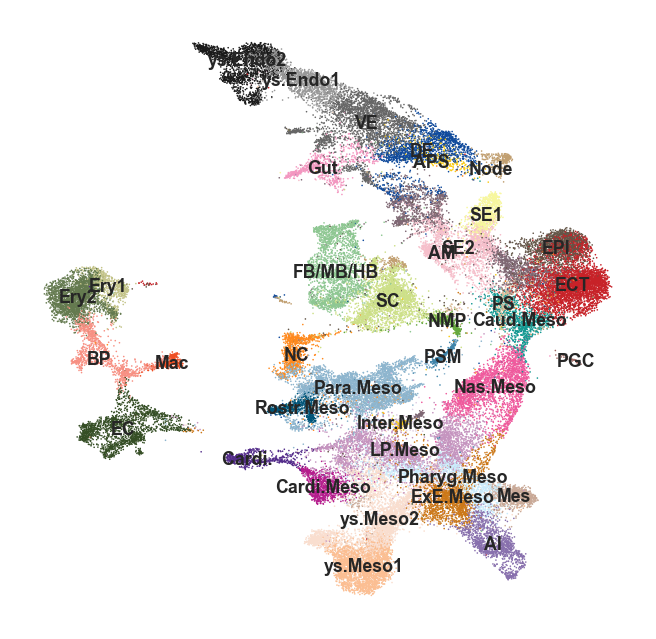

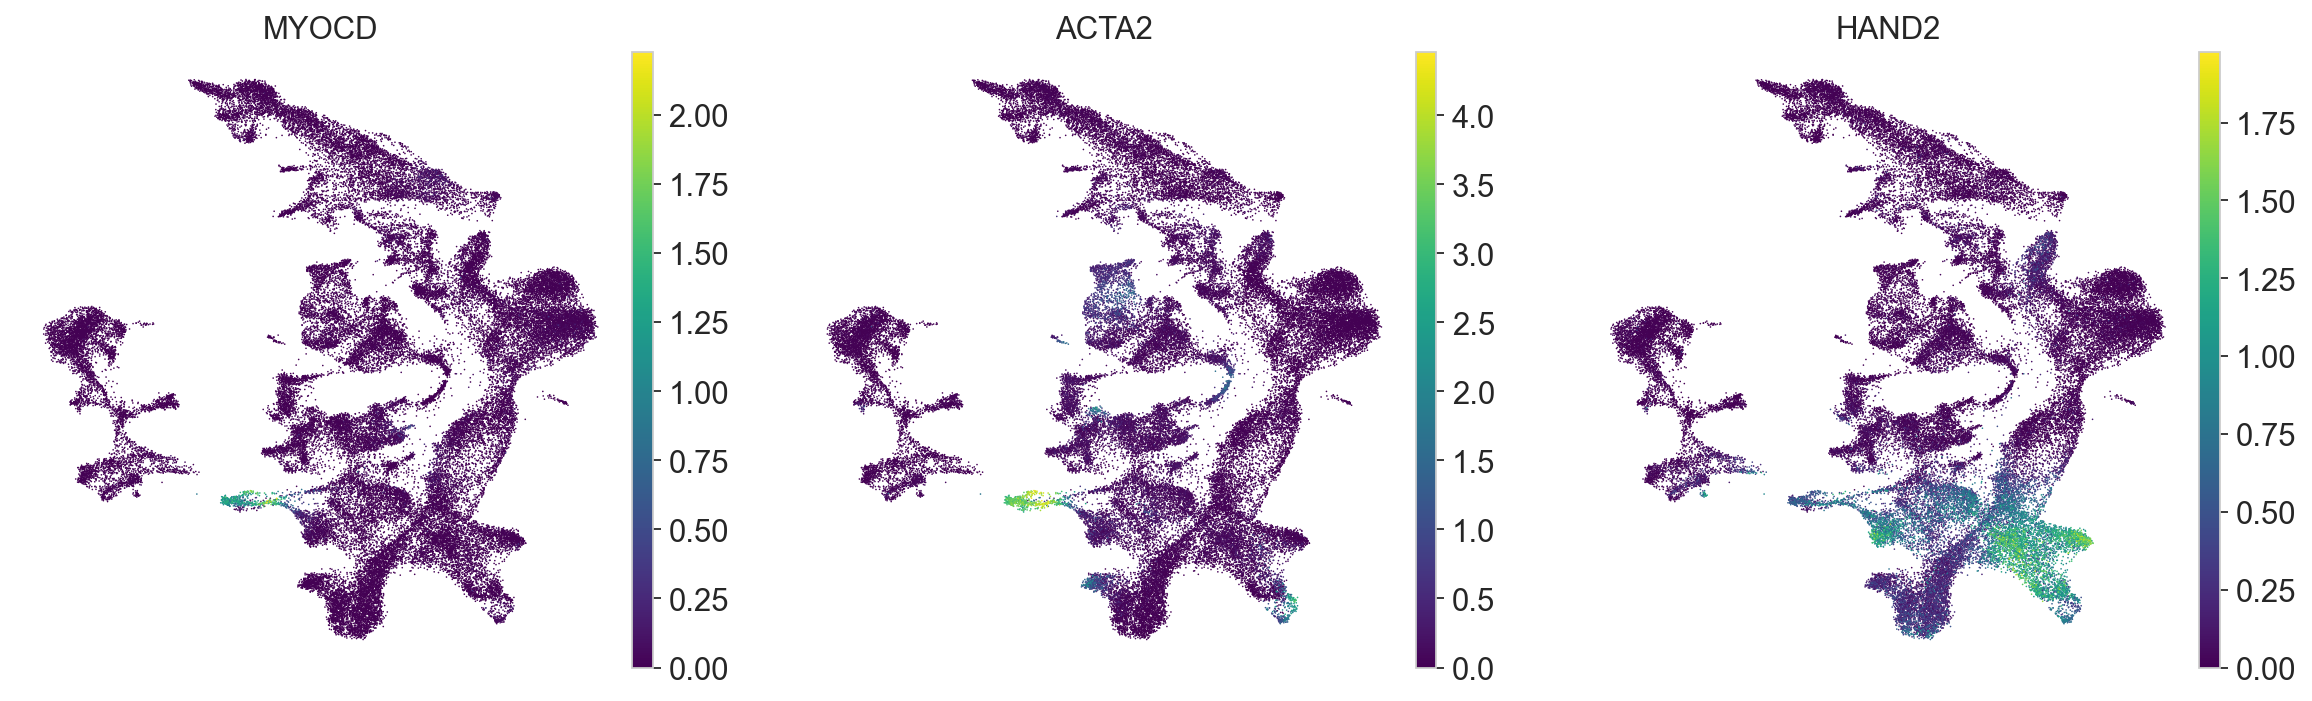

In [18]:
sc.pl.embedding(
    adata_monkey_raw,
    basis = 'X_umap_all2monkey_scanvi',
    frameon = False,
    color = 'cell_type',
    palette = monkey_cmap,
    title = '',
    legend_loc = 'on data',
    legend_fontsize = 8,
)
sc.pl.embedding(
    adata_monkey_raw_raw,
    basis = 'X_umap_all2monkey_scanvi',
    frameon = False,
    color = ['MYOCD', 'ACTA2', 'HAND2'],
    layer = 'magic',
    legend_loc = 'on data',
    legend_fontsize = 8,
    cmap = 'viridis'
)